In [2]:
import numpy as np
import importlib
import util as uti
import matplotlib.pyplot as plt
importlib.reload(uti)

# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import GroverOperator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.quantum_info import state_fidelity

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_textbook.tools import vector2latex
%matplotlib inline

/home/kinga/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


In [3]:
def recur_list_test(ll, s): # list argument passed as reference copy
    if s < 7:
        recur_list_test(ll, s+1)
        ll.append(s)
    ll = [1] # has no effect (new assignment to reference copy)

In [4]:
ol = []
recur_list_test(ol, 2)

In [5]:
ol

[6, 5, 4, 3, 2]

In [6]:
list(range(3,7))

[3, 4, 5, 6]

In [7]:
def recursive_compute_beta(input_vector, betas):
    """
    recursive rotation computetation
    source: https://www.nature.com/articles/s41598-021-85474-1.pdf
    """
    if len(input_vector) > 1:
        new_x = []
        beta = []
        for k in range(0, len(input_vector), 2):
            norm = np.sqrt(input_vector[k] ** 2 + input_vector[k + 1] ** 2)
            new_x.append(norm)
            if norm == 0:
                beta.append(0)
            else:
                if input_vector[k] < 0:
                    beta.append(2 * np.pi - 2 * np.arcsin(input_vector[k + 1] / norm))
                else:
                    beta.append(2 * np.arcsin(input_vector[k + 1] / norm))
        recursive_compute_beta(new_x, betas)
        betas.append(beta)

In [8]:
def index(k, circuit, control_qubits, numberof_controls):
    binary_index = '{:0{}b}'.format(k, numberof_controls)
    for j, qbit in enumerate(control_qubits):
        if binary_index[j] == '1':
            circuit.x(qbit)

In [9]:
def generate_circuit(betas, qcircuit, quantum_input, num_qubits):
    numberof_controls = 0  # number of controls
    control_bits = []
    for angles in betas:
        if numberof_controls == 0:
            qcircuit.ry(angles[0], quantum_input[num_qubits-1])
            numberof_controls += 1
            control_bits.append(quantum_input[num_qubits-1])
        else:
            for k, angle in enumerate(reversed(angles)):
                index(k, qcircuit, control_bits, numberof_controls)

                qcircuit.mcry(angle, control_bits, quantum_input[num_qubits - 1 - numberof_controls],
                              None, mode='noancilla')

                index(k, qcircuit, control_bits, numberof_controls)
                
            control_bits.append(quantum_input[num_qubits - 1 - numberof_controls])
            numberof_controls += 1

In [10]:
def amplitude_encoding(input_vector):
    """
    load real vector x to the amplitude of a quantum state
    source: https://www.nature.com/articles/s41598-021-85474-1.pdf
    """
    num_qubits = int(np.log2(len(input_vector)))
    quantum_data = QuantumRegister(num_qubits)
    qcircuit = QuantumCircuit(quantum_data)
    newx = np.copy(input_vector)
    betas = []
    recursive_compute_beta(newx, betas)
    generate_circuit(betas, qcircuit, quantum_data, num_qubits)
    return qcircuit

In [11]:
v1 = np.array([0.2, 1.5, 0.7, 0.99])
qc_v1 = amplitude_encoding(v1)

In [12]:
qc_v1.draw()

┌─────────────────┐     ┌─────────────────┐     
q0_0: ─────────────┤ U(1.9107,0,0,0) ├─────┤ U(2.8765,0,0,0) ├─────
      ┌───────────┐└────────┬────────┘┌───┐└────────┬────────┘┌───┐
q0_1: ┤ Ry(1.351) ├─────────■─────────┤ X ├─────────■─────────┤ X ├
      └───────────┘                   └───┘                   └───┘

In [13]:
v2 = np.array([3.5, 0.5, 0.02, 6.7])
qc_v2 = amplitude_encoding(v2)

In [14]:
qc_v2.draw()

┌─────────────────┐     ┌──────────────────┐     
q1_0: ──────────────┤ U(3.1356,0,0,0) ├─────┤ U(0.28379,0,0,0) ├─────
      ┌────────────┐└────────┬────────┘┌───┐└────────┬─────────┘┌───┐
q1_1: ┤ Ry(2.1705) ├─────────■─────────┤ X ├─────────■──────────┤ X ├
      └────────────┘                   └───┘                    └───┘

In [15]:
# basic swap test directly on quantum states that are rotated against each other
def swap_test(v1, v2):
    
    backend = Aer.get_backend('qasm_simulator')
    # create circuit with n qubits and one classical bit for measurement
    # qubits: first: ancilla, second: input vector, third: cluster center
    #(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
    n = int(np.log2(len(v1))) if len(v1) > 1 else 1
    qc = QuantumCircuit(n*2+1, 1, name="swap_test")

    # control qubit default 0
    # append first vector
    qc.append(v1, range(1,n+1))
    # append second vector
    qc.append(v2, range(n+1,n*2+1))
    # third qubit init to phi
    qc.barrier()
    # apply hadamard to control
    qc.h(0)
    # swap pairwise qubits controlled on ancilla
    for i in range(n):
        qc.cswap(0,i+1,i+n+1)
    # apply second hadamard
    qc.h(0)
    # measure control qubit
    qc.measure(0,0)
    qc.draw()
    
    shots = 1024
    #qobj = assemble(qc, backend)
    qc_transpiled = transpile(qc, backend) # have to transpile first because of amplitued encoded circuits
    results = backend.run(qc_transpiled, shots = shots).result()
    #results = backend.run(qobj).result()
    answer = results.get_counts()

    return qc, answer

In [16]:
qc, answer = swap_test(qc_v1, qc_v2)

In [17]:
qc.draw()

░ ┌───┐      ┌───┐┌─┐
q_0: ───────────────░─┤ H ├─■──■─┤ H ├┤M├
     ┌────────────┐ ░ └───┘ │  │ └───┘└╥┘
q_1: ┤0           ├─░───────X──┼───────╫─
     │  circuit-0 │ ░       │  │       ║ 
q_2: ┤1           ├─░───────┼──X───────╫─
     ├────────────┤ ░       │  │       ║ 
q_3: ┤0           ├─░───────X──┼───────╫─
     │  circuit-1 │ ░          │       ║ 
q_4: ┤1           ├─░──────────X───────╫─
     └────────────┘ ░                  ║ 
c: 1/══════════════════════════════════╩═
                                       0

In [18]:
def calculate_overlap(answer, state='0'):
    shots = answer[state] if len(answer) == 1 else answer['0']+answer['1']
    return np.abs(answer[state]/shots - 0.5) * 2

In [19]:
# caluclate overlaps for different qubit rotations
dist_eucl = []
overlaps = []
vectors = []
low = -5
a_real = np.random.uniform(low=low, high=5, size=4)
a = amplitude_encoding(a_real)
for i in range(45):
        b_real = np.random.uniform(low=low, high=5, size=4)
        b = amplitude_encoding(b_real)
        _, answer = swap_test(a, b)
        overlap = calculate_overlap(answer)
        dist_eucl.append(np.linalg.norm(a_real-b_real))
        overlaps.append(overlap)
        vectors.append((a,b))

Text(0, 0.5, 'overlap')

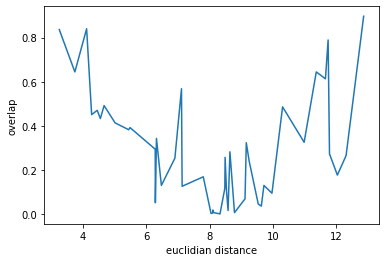

In [20]:
# plot results
dist_eucl_sorted, overlaps_sorted, vectors_sorted = zip(*sorted(zip(dist_eucl, overlaps, vectors)))
plt.plot(dist_eucl_sorted, overlaps_sorted)
plt.xlabel('euclidian distance')
plt.ylabel('overlap')

In [21]:
def normalize(v):
    return v / np.linalg.norm(v)

In [22]:
def get_encoding_circuit(*vv, state=True): # vv: tuple of vectors to be encoded
    
    sz = int(np.log2(len(vv[0])))
    
    qc = QuantumCircuit(len(vv)*sz)

    for i, v in enumerate(vv):
        qc.initialize(v, range(i*sz, (i+1)*sz))
    
    if state:
        qc.save_statevector()
    
    return qc

In [23]:
def run_encoding_circuit(qc):
    backend = Aer.get_backend('statevector_simulator')
    qc = transpile(qc, backend)
    result = backend.run(qc).result()
    return result.get_statevector()

## single qubit: + vs -

### positive vec

In [24]:
a = normalize(np.array([2,3]))

qc_a = get_encoding_circuit(a)

In [25]:
qc_a.draw()

┌────────────────────────────┐ ░ 
q_0: ┤ Initialize(0.5547,0.83205) ├─░─
     └────────────────────────────┘ ░

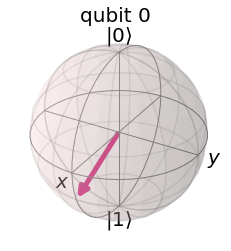

In [26]:
state_vec_a = run_encoding_circuit(qc_a)
plot_bloch_multivector(state_vec_a)

In [27]:
vector2latex(state_vec_a, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

### negative vec

In [31]:
b = normalize(np.array([-2,-3]))
qc_b = get_encoding_circuit(b)

In [32]:
qc_b.draw()

┌──────────────────────────────┐ ░ 
q_0: ┤ Initialize(-0.5547,-0.83205) ├─░─
     └──────────────────────────────┘ ░

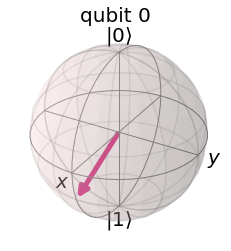

In [33]:
state_vec_b = run_encoding_circuit(qc_b)
plot_bloch_multivector(state_vec_b)

#### negative vector differs only by global phase -> no distinction in measurement

In [34]:
vector2latex(state_vec_b, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

### fidelity

In [35]:
print(state_fidelity(state_vec_a, state_vec_a))

1.0


In [36]:
print(state_fidelity(state_vec_b, state_vec_b))

1.0


### fidelity for a and b == 1

In [37]:
print(state_fidelity(state_vec_a, state_vec_b))

1.0


### swap test

In [38]:
qc_a = get_encoding_circuit(a, state=False)
_, answer = swap_test(qc_a, qc_a)

In [39]:
calculate_overlap(answer)

1.0

In [40]:
qc_b = get_encoding_circuit(b, state=False)
_, answer = swap_test(qc_b, qc_b)

In [41]:
calculate_overlap(answer)

1.0

### swap test for a and b == 1

In [42]:
_, answer = swap_test(qc_a, qc_b)

In [43]:
calculate_overlap(answer)

1.0

# multi qubit + vs -

In [44]:
qc_ab = get_encoding_circuit(a, b)

In [45]:
qc_ab.draw()

┌────────────────────────────┐  ░ 
q_0: ─┤ Initialize(0.5547,0.83205) ├──░─
     ┌┴────────────────────────────┴┐ ░ 
q_1: ┤ Initialize(-0.5547,-0.83205) ├─░─
     └──────────────────────────────┘ ░

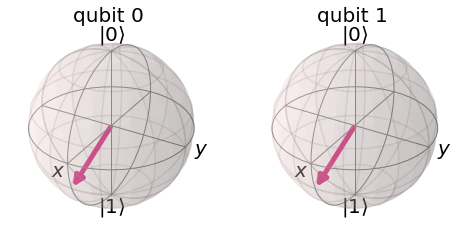

In [46]:
state_vec_ab = run_encoding_circuit(qc_ab)
plot_bloch_multivector(state_vec_ab)

#### negative vector differs only by global phase -> no distinction in measurement

In [47]:
vector2latex(state_vec_ab, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [48]:
qc_aa = get_encoding_circuit(a, a)

In [49]:
qc_aa.draw()

┌────────────────────────────┐ ░ 
q_0: ┤ Initialize(0.5547,0.83205) ├─░─
     ├────────────────────────────┤ ░ 
q_1: ┤ Initialize(0.5547,0.83205) ├─░─
     └────────────────────────────┘ ░

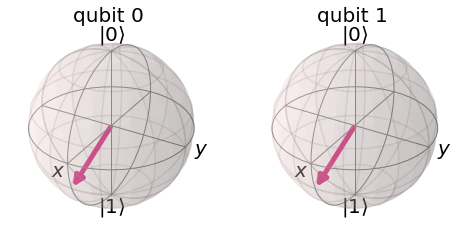

In [50]:
state_vec_aa = run_encoding_circuit(qc_aa)
plot_bloch_multivector(state_vec_aa)

#### negative vector differs only by global phase -> no distinction in measurement

In [51]:
vector2latex(state_vec_aa, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [99]:
low = 0
sz = 2
a = np.random.uniform(low=low, high=5, size=sz)
a = normalize(a)
b = np.random.uniform(low=low, high=5, size=sz)
b = normalize(b)

In [88]:
qc = get_encoding_circuit(a,b,sz=sz)

In [89]:
qc.draw()

┌────────────────────────────┐  ░ 
q_0: ─┤ Initialize(0.5547,0.83205) ├──░─
     ┌┴────────────────────────────┴┐ ░ 
q_1: ┤ Initialize(-0.83205,-0.5547) ├─░─
     └──────────────────────────────┘ ░

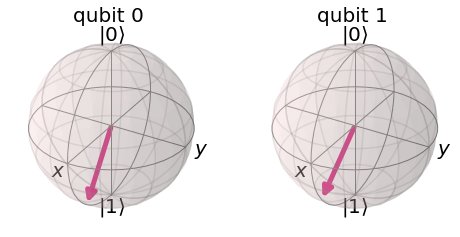

In [79]:
qc = transpile(qc, backend)
result = backend.run(qc).result()
plot_bloch_multivector(result.get_statevector())

## + +

In [80]:
a = normalize(np.array([2,3]))
b = normalize(np.array([-2,-3]))
qc = get_encoding_circuit(a,b,sz)
qc.draw()

┌────────────────────────────┐  ░ 
q_0: ─┤ Initialize(0.5547,0.83205) ├──░─
     ┌┴────────────────────────────┴┐ ░ 
q_1: ┤ Initialize(-0.5547,-0.83205) ├─░─
     └──────────────────────────────┘ ░

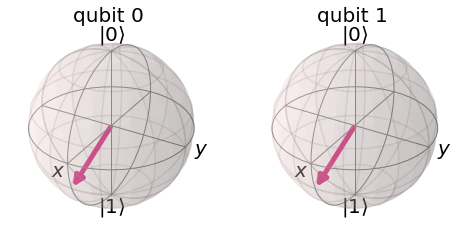

In [81]:
qc = transpile(qc, backend)
result = backend.run(qc).result()
state_vec = result.get_statevector()
plot_bloch_multivector(state_vec)

In [86]:
vector2latex(state_vec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

## + -

In [83]:
a = normalize(np.array([2,3]))
b = normalize(np.array([-3,-2]))
qc = get_encoding_circuit(a,b,sz)
qc.draw()

┌────────────────────────────┐  ░ 
q_0: ─┤ Initialize(0.5547,0.83205) ├──░─
     ┌┴────────────────────────────┴┐ ░ 
q_1: ┤ Initialize(-0.83205,-0.5547) ├─░─
     └──────────────────────────────┘ ░

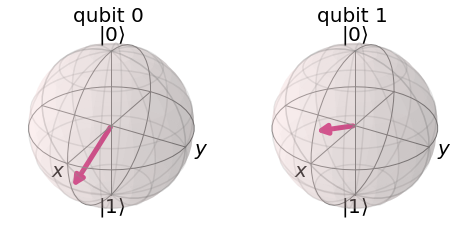

In [84]:
qc = transpile(qc, backend)
result = backend.run(qc).result()
state_vec = result.get_statevector()
plot_bloch_multivector(state_vec)

In [49]:
vector2latex(answer, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [52]:
list(range(10,100,10))

[10, 20, 30, 40, 50, 60, 70, 80, 90]